In [137]:
import numpy as np, matplotlib.pyplot as plt, os, gym
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt, matplotlib.patches as pat
from scipy.spatial import KDTree
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from gym import spaces
import warnings

warnings.filterwarnings("ignore")

In [138]:
class Car_Sim():
    """
    initial_states: initial states of the car = [x position, y position, heading angle, speed, steering angle]
    dt: time step

    U: control input = [acceleration, steering change], both are between [-1,1]
    """
    def __init__(self, initial_states = np.zeros(5), dt = 0.02):
        """ states = [x y theta speed steer] | input = [accel. dsteer]"""
        self.states = initial_states
        self.initial_states = initial_states
        self.dt = dt

        self.L = 3 # car length in meters
        self.W = 1.5 # car width in meters
        self.MAX_LIN_ACC = 5 # m/s^2
        self.MAX_STEER_CHANGE = 10*np.pi/180 
        self.MAX_SPEED = 20/3.6 # 20km/h
    
    def state_dot(self, X, U):
        ct = np.cos(X[2]); st = np.sin(X[2])
        
        Xd = np.zeros_like(X)
        # xdot, ydot
        Xd[0] = X[3]*ct
        Xd[1] = X[3]*st
        # thetadot
        Xd[2] = X[3]/self.L * np.tan(X[4])
        # change in speed
        Xd[3] = U[0]*self.MAX_LIN_ACC
        # change in steering angle
        Xd[4] = U[1]*self.MAX_STEER_CHANGE

        return Xd

    def step(self, uvec):
        """uvec[0]: change in speed | uvec[1] : change in steer both between -1 and 1"""
        uvec[0] = min(max(uvec[0],-1.),1.)
        uvec[1] = min(max(uvec[1],-1.),1.)

        self.states = self.RK4(self.states, uvec, self.dt)

        self.states[3] = min(max(self.states[3],0),self.MAX_SPEED) # max speed is ~100kmh
        self.states[4] = min(max(self.states[4],-np.pi/2),np.pi/2) # abs(steering) < pi/2 

        return self.states

    def RK4(self,X,U,dt):
        # Calculate slope estimates
        K1 = self.state_dot(X, U)
        K2 = self.state_dot(X + K1 * dt / 2, U)
        K3 = self.state_dot(X + K2 * dt / 2, U)
        K4 = self.state_dot(X + K3 * dt, U)

        # Calculate x[k+1] estimate using combination of slope estimates
        X_n = X + 1/6 * (K1 + 2*K2 + 2*K3 + K4) * dt

        return X_n

    def get_car_points(self):
        angle = self.states[2]
        ct = np.cos(angle); st = np.sin(angle)
        points = np.array([
            np.array([self.L/2, self.W/2]),
            np.array([self.L/2, -self.W/2]),
            np.array([-self.L/2, -self.W/2]),
            np.array([-self.L/2, self.W/2])])
        points = points@np.array([[ct, st],[-st, ct]])
        return (self.states[:2] + points)

    def get_car_polygon(self):
        return Polygon(self.get_car_points())

    def plot(self):
        plt.gca().add_patch(pat.Polygon(self.get_car_points(),color='blue', fill=True))
    
    def reset(self):
        self.states = self.initial_states

Create the static environment for the simulation consisting of obstacles which is implemented in _Obstacle_ class (inspired by: https://github.com/FelicienC/RRT-Dubins)

In [139]:
class Obstacle:
    def __init__(self, map_dimensions, size, nb_pts):
        self.center = np.array([np.random.rand()*map_dimensions[0],
                                np.random.rand()*map_dimensions[1]])
        
        angles = sorted((np.random.rand()*2*np.pi for _ in range(nb_pts)))
        self.points = \
            np.array([self.center +\
                      np.array([size*np.cos(angle), size*np.sin(angle)])\
                      for angle in angles])
        self.bounding_box = (min(self.points, key=lambda x: x[0])[0],
                             min(self.points, key=lambda x: x[1])[1],
                             max(self.points, key=lambda x: x[0])[0],
                             max(self.points, key=lambda x: x[1])[1])
        self.polygon = Polygon(self.points)

    def colides(self, polygon):
        return self.polygon.intersects(polygon)
    
    def distance(self,polygon):
        return self.polygon.distance(polygon)

    def plot(self):
        plt.gca().add_patch(pat.Polygon(self.points, color='black', fill=True))

In [140]:
class StaticEnvironment:
    def __init__(self, dimensions, nb_obstacles, A, B):
        self.dimensions = dimensions
        self.obstacles = [Obstacle(dimensions, 0.05*dimensions[0],5)\
                          for _ in range(nb_obstacles)]
        self.kdtree = KDTree([obs.center for obs in self.obstacles])

        self.start_point = A
        self.end_point = B
    
    def is_free(self, center, car_poly : Polygon):
        x,y = center
        if x < 0 or x > self.dimensions[0] or y < 0 or y > self.dimensions[1]:
            return False
        obstacles = self.close_obstacles(x,y, nb_obstacles=2)
        for obstacle in obstacles:
            if obstacle.colides(car_poly):
                return False
        return True

    def distances_to_close_obstacles(self, center, car_poly:Polygon,nb_obstacles=3):
        x,y = center
        obstacles = self.close_obstacles(x,y,nb_obstacles)
        dists = np.zeros(nb_obstacles)
        for i,obst in enumerate(obstacles):
            dists[i] = obst.distance(car_poly)
        return dists

    def close_obstacles(self, x, y, nb_obstacles=1):
        return [self.obstacles[index]\
                for index in self.kdtree.query((x, y), nb_obstacles)[1]]

    def plot(self, close=False, display=True):        
        plt.ion() if display else plt.ioff()
        for obstacle in self.obstacles:
            obstacle.plot()
        plt.plot(self.start_point[0], self.start_point[1], marker="o", \
                 markersize=7,markeredgecolor="black", markerfacecolor="green")
        plt.plot(self.end_point[0], self.end_point[1], marker="o",  \
                 markersize=7,markeredgecolor="black", markerfacecolor="red")
        plt.text(*(self.start_point-np.array([4,0])), "A", fontsize=12,c="green")
        plt.text(*(self.end_point+np.array([2,0])), "B", fontsize=12,c="red")
        plt.gca().set_xlim(0, self.dimensions[0])
        plt.gca().set_ylim(0, self.dimensions[1])
        if close:
            plt.close()

In [141]:
class CarSimEnv():
    def __init__(self, heading = 0., speed = 0., steer= 0., dt = 0.02, dimensions = (60,50), 
                 nb_obstacles = 15, A = np.array([2.,4.]), B = np.array([55.,45.])):
        self.car_sim = Car_Sim(np.concatenate((A,np.array([heading,speed,steer]))),dt)
        self.static_env = StaticEnvironment(dimensions,nb_obstacles,A, B)
        self.goal_pos = B

    def check_collision(self):
        return (not self.static_env.is_free(self.car_sim.states[:2],
                                            self.car_sim.get_car_polygon()))
    
    def dist_to_goal(self):
        return np.linalg.norm(self.car_sim.states[:2]-self.goal_pos)
    
    def distances_to_close_obstacles(self):
        return self.static_env.distances_to_close_obstacles(self.car_sim.states[:2],
                                                            self.car_sim.get_car_polygon())
    
    def has_reached_goal(self,eps):
        return self.dist_to_goal() < eps

    def plot(self):
        self.static_env.plot(display=False)
        self.car_sim.plot()
 

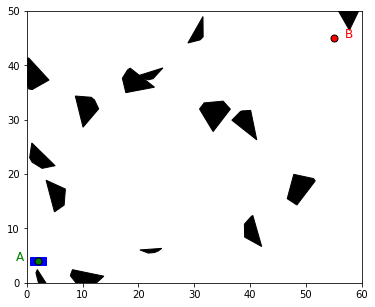

In [142]:
np.random.seed(11)
cse = CarSimEnv()
plt.figure(1,figsize=(6,5))
cse.plot()

Create the gym environment for that _CarSimEnv_, just the gymification of it.

In [157]:
class CarGymEnv(gym.Env):
    metadata = {'render_modes' : ['human']}

    def __init__(self) -> None:
        super().__init__()

        self.carsimenv = CarSimEnv()
        self.time = 0.
        self.steps = 0
        self.MAX_SIM_TIME = 30
        self.current_best_distance = self.carsimenv.dist_to_goal()
        self.initial_distance = self.current_best_distance
        self.done_info = ""

        # state_sample = [x,y,heading,speed,steer] from R^5
        self.action_space = spaces.Box(
            low =  np.array([ -1., -1.]),
            high =  np.array([1.,   1.]))
        self.observation_space = spaces.Box(
            low =  np.array([0.,0.,-np.inf,0.,-np.pi/2]),
            high = np.array([200.,200.,np.inf,self.carsimenv.car_sim.MAX_SPEED,np.pi/2]))
        
        self.reset()
    
    def step(self, action):
        self.time += self.carsimenv.car_sim.dt
        self.steps += 1

        prev_dist = self.carsimenv.dist_to_goal()
        new_states = self.carsimenv.car_sim.step(action)
        new_dist = self.carsimenv.dist_to_goal()

        # calculate reward
        reward = -1. # r_step
        # r_closer
        reward += (prev_dist-new_dist)*5. #
        # r_closer_ring_around_goal
        if new_dist < self.current_best_distance-1.:
            self.current_best_distance = new_dist
            reward += 15.*(self.initial_distance-new_dist)/self.initial_distance
        # r_input_norm
        reward -= np.abs(action[1])
        # r_speed
        #reward += self.carsimenv.car_sim.states[3]/27. # normalize with max speed (~27m/s)
        # r_close_to_obstacle
        dists_to_close_obs = self.carsimenv.distances_to_close_obstacles()
        clipped_dists = np.clip(3.-dists_to_close_obs,a_min=0.,a_max=3.)/6.
        reward -= np.sum(clipped_dists)

        crashed = self.carsimenv.check_collision()
        reached_goal = self.carsimenv.has_reached_goal(0.5)

        # r_crashed
        if crashed:
            self.done_info = "crashed"
            reward -= 100.
        # r_success
        if reached_goal:
            print("DONE!")
            self.done_info = "reached_goal"
            reward += 100.
        # r_maxiter
        reached_maxiter = False
        if self.time >= self.MAX_SIM_TIME:
            self.done_info = "reached_maxiter"
            reward -= 50.
            reached_maxiter = True

        # check if done
        done = (crashed or reached_goal or reached_maxiter)

        # info
        info = {"steps" : self.steps, "sim_time" : self.time, "done_info" : self.done_info}

        return new_states, reward, done, info

    def reset(self):
        self.carsimenv.car_sim.reset()
        self.time = 0.
        self.steps = 0
        self.current_best_distance = self.initial_distance
        self.done_info = ""
        return self.carsimenv.car_sim.states

    def render(self,mode="human"):
        if mode == "human":
            self.carsimenv.plot()

    def close(self):
        pass

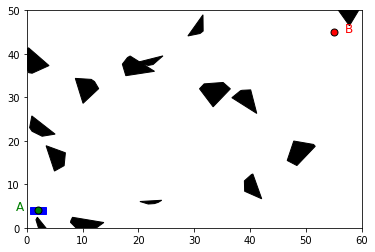

[[2. 4. 0. 0. 0.]
 [2. 4. 0. 0. 0.]
 [2. 4. 0. 0. 0.]
 [2. 4. 0. 0. 0.]]


In [158]:
np.random.seed(11)
env = CarGymEnv()
plt.figure()
env.render()
plt.show()

env = make_vec_env(CarGymEnv, n_envs=4)
print(env.reset())

In [129]:
log_dir = "logs"
models_dir = "models/PPO"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

PPO

In [ ]:
model = PPO("MlpPolicy", env, verbose=1,device="cuda")

TIME_STEPS = 15000
i = 1
while True:
    model.learn(total_timesteps=TIME_STEPS,reset_num_timesteps=False)
    if i%20 == 0:
        model.save(f"{models_dir}/PPO_carsim_{i//20}")
    i+=1

Test the trained agent

In [159]:
np.random.seed(11)
env = CarGymEnv()

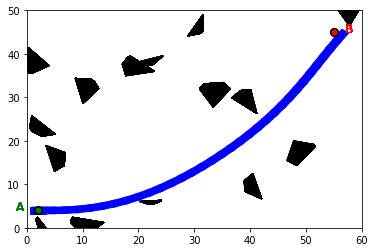

-186.38359688407508


In [160]:
done = False

model = PPO.load("D:\ITU\TUBITAK Proje\Codes\Car RL\models\PPO_carsim_4.zip")
i=0
obs = env.reset()
plt.figure()
plt.ion()
cum_rew = 0
pos_vec = []
while not done:
    pos_vec.append(env.carsimenv.car_sim.states[:2])
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    cum_rew+=reward
    if i%20==0:    
        env.render()
    i+=1

plt.show()
print(cum_rew)
pos_vec = np.array(pos_vec)

Visualize the trajectory that car followed

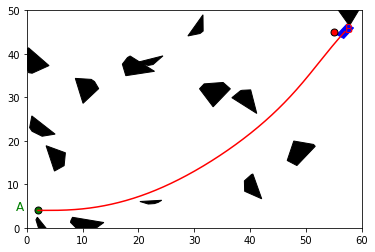

In [161]:
col = "green" if info["done_info"] == "reached_goal" else "red"

plt.figure()
env.render()
plt.plot(pos_vec[:,0],pos_vec[:,1], color=col)
plt.show()